# <center>**交通标志物识别**</center>

## **陈羽 唐伟铭 尹翔飞**
___

首先导入整篇报告中所需的包

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from math import sqrt, ceil

## **一、数据描述**
___

### 1. **背景**
随着高级驾驶辅助系统(advanced driver assistance systems,ADAS)和无人驾驶技术快速发展，交通标志识别方法成为辅助驾驶员实现安全驾驶的一个重要研究方向，对于减少交通事故的发生有重要的意义。

### 2. **任务**
利用带有标签的交通标志图像数据，建立分类模型。

### 3. **数据展示**

我们的全部数据包括以下部分文件：

In [2]:
for i in os.listdir('traffic-signs-preprocessed'):
    print(i)

data0.pickle
data1.pickle
data2.pickle
data3.pickle
data4.pickle
data5.pickle
data6.pickle
data7.pickle
data8.pickle
datasets_preparing.py
labels.pickle
label_names.csv
mean_image_gray.pickle
mean_image_rgb.pickle
std_gray.pickle
std_rgb.pickle
test.pickle
train.pickle
valid.pickle


我们本次报告只采用data1这个数据集，把它导入data

In [3]:
data = pickle.load(open("traffic-signs-preprocessed/data2.pickle","rb"))

data是一个字典，包括以下几个keys：

In [4]:
data.keys()

dict_keys(['y_test', 'y_validation', 'x_validation', 'x_train', 'y_train', 'labels', 'x_test'])

下面画图显示训练集中部分图像数据

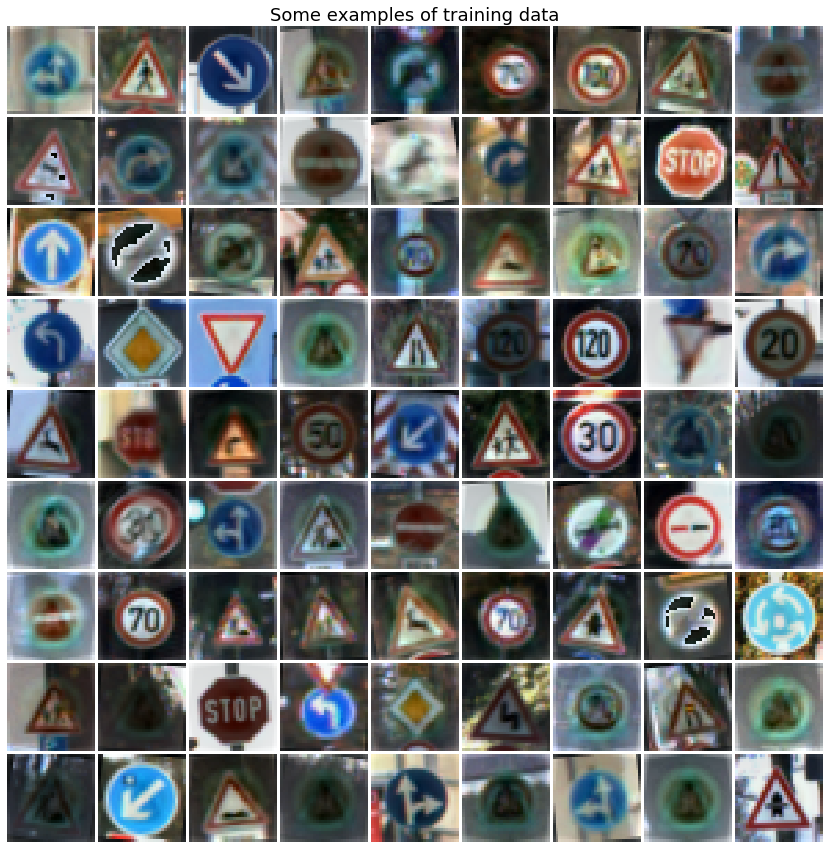

In [5]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1
    return grid

# Visualizing some examples of training data
examples = data['x_train'].transpose(0, 2, 3, 1)[:81, :, :, :]

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()
plt.close()

## **二、训练模型**
___

### 1. **NN**
普通神经网络比卷积神经网络更容易训练，我们先训练一个NN模型看下分类效果。
首先导入训练集、验证集和测试集数据。

In [6]:
X_test = data['x_test'].transpose(0, 2, 3, 1)
X_validation = data['x_validation'].transpose(0, 2, 3, 1)
Y_test = data['y_test']
Y_validation = data['y_validation']
X_train = data['x_train'].transpose(0, 2, 3, 1)
Y_train = data['y_train']
del data

建立模型

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32,32,3)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

训练模型

In [8]:
model.fit(X_train, Y_train, epochs=10, verbose = 1,validation_data = (X_validation, Y_validation))

Train on 86989 samples, validate on 4410 samples
Epoch 1/10
86989/86989 [==============================] - 14s 165us/sample - loss: 1.1549 - accuracy: 0.6942 - val_loss: 0.9717 - val_accuracy: 0.7458
Epoch 2/10
86989/86989 [==============================] - 14s 159us/sample - loss: 0.5828 - accuracy: 0.8433 - val_loss: 1.0404 - val_accuracy: 0.7635
Epoch 3/10
86989/86989 [==============================] - 13s 145us/sample - loss: 0.4758 - accuracy: 0.8719 - val_loss: 1.0140 - val_accuracy: 0.7905
Epoch 4/10
86989/86989 [==============================] - 13s 146us/sample - loss: 0.4194 - accuracy: 0.8871 - val_loss: 1.1881 - val_accuracy: 0.8050
Epoch 5/10
86989/86989 [==============================] - 13s 148us/sample - loss: 0.3777 - accuracy: 0.8976 - val_loss: 1.0953 - val_accuracy: 0.8132
Epoch 6/10
86989/86989 [==============================] - 13s 151us/sample - loss: 0.3442 - accuracy: 0.9068 - val_loss: 1.0569 - val_accuracy: 0.8032
Epoch 7/10
86989/86989 [=====================

模型测试

In [9]:
model.evaluate(X_test,  Y_test, verbose=2)

12630/1 - 1s - loss: 1.5870 - accuracy: 0.8345


[1.6900093765930817, 0.834521]

### 2. **CNN**

建立模型

In [10]:
# CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 1, activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
    tf.keras.layers.Conv2D(128, 5, activation='relu',padding="same"),
    tf.keras.layers.MaxPool2D(padding = 'same',strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

训练模型

In [11]:
model.fit(x=X_train,y=Y_train,batch_size=100,epochs=5,verbose=1,
          validation_data = (X_validation, Y_validation),
          shuffle=False,initial_epoch=0)

Train on 86989 samples, validate on 4410 samples
Epoch 1/5
86989/86989 [==============================] - 831s 10ms/sample - loss: 0.5637 - accuracy: 0.8380 - val_loss: 0.4090 - val_accuracy: 0.8952
Epoch 2/5
86989/86989 [==============================] - 941s 11ms/sample - loss: 0.0606 - accuracy: 0.9835 - val_loss: 0.4660 - val_accuracy: 0.8905
Epoch 3/5
86989/86989 [==============================] - 922s 11ms/sample - loss: 0.0375 - accuracy: 0.9890 - val_loss: 0.5029 - val_accuracy: 0.9195
Epoch 4/5
86989/86989 [==============================] - 928s 11ms/sample - loss: 0.0249 - accuracy: 0.9928 - val_loss: 0.7855 - val_accuracy: 0.8950
Epoch 5/5
86989/86989 [==============================] - 1055s 12ms/sample - loss: 0.0250 - accuracy: 0.9931 - val_loss: 0.6293 - val_accuracy: 0.9116


模型测试

In [12]:
model.evaluate(X_test,  Y_test, verbose=2)

12630/1 - 44s - loss: 0.6137 - accuracy: 0.9213


[0.492558723918486, 0.9212985]

## **三、模型比较**
___

Model|ACC(train set)|ACC(test set)|Train time
:--:|:--:|:--:|:--:
NN|0.9248|0.8345|20s
CNN|0.98862|0.92526|40min
SVM|0.98866|0.83444|3.5h
KNN|-|0.50736|1.06h(train time)